# QPE

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import QFT
import numpy as np

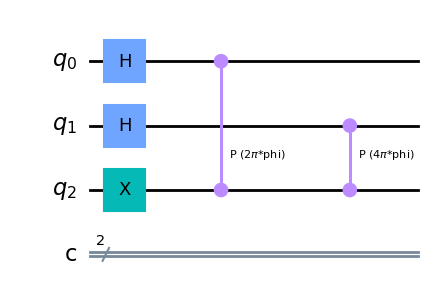

In [2]:
num_qubits = 2
alpha=4/9
phi = Parameter('phi')
qc = QuantumCircuit(num_qubits + 1, num_qubits)
qc.h([i for i in range(num_qubits)])
qc.x(num_qubits)


for i in range(num_qubits):
    qc.cp(theta=phi*2**i*2*np.pi, target_qubit=num_qubits, control_qubit=i)# - i -1)
qc.draw(output="mpl")

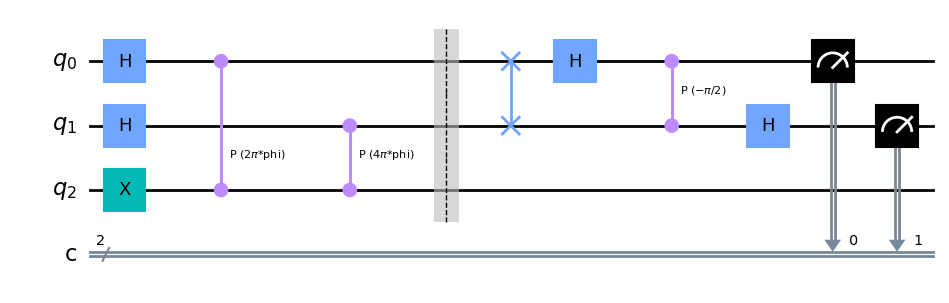

In [3]:
qft_qc = QFT(num_qubits, inverse=True)#, do_swaps=True)
qc.barrier()
qft_qc.decompose().draw(output = "mpl")
qc.compose(qft_qc.decompose(), [i for i in range(num_qubits)], inplace=True)
qubit_indices = [i for i in range(num_qubits)]
qc.measure(qubit_indices, qubit_indices)
qc.draw(output="mpl")

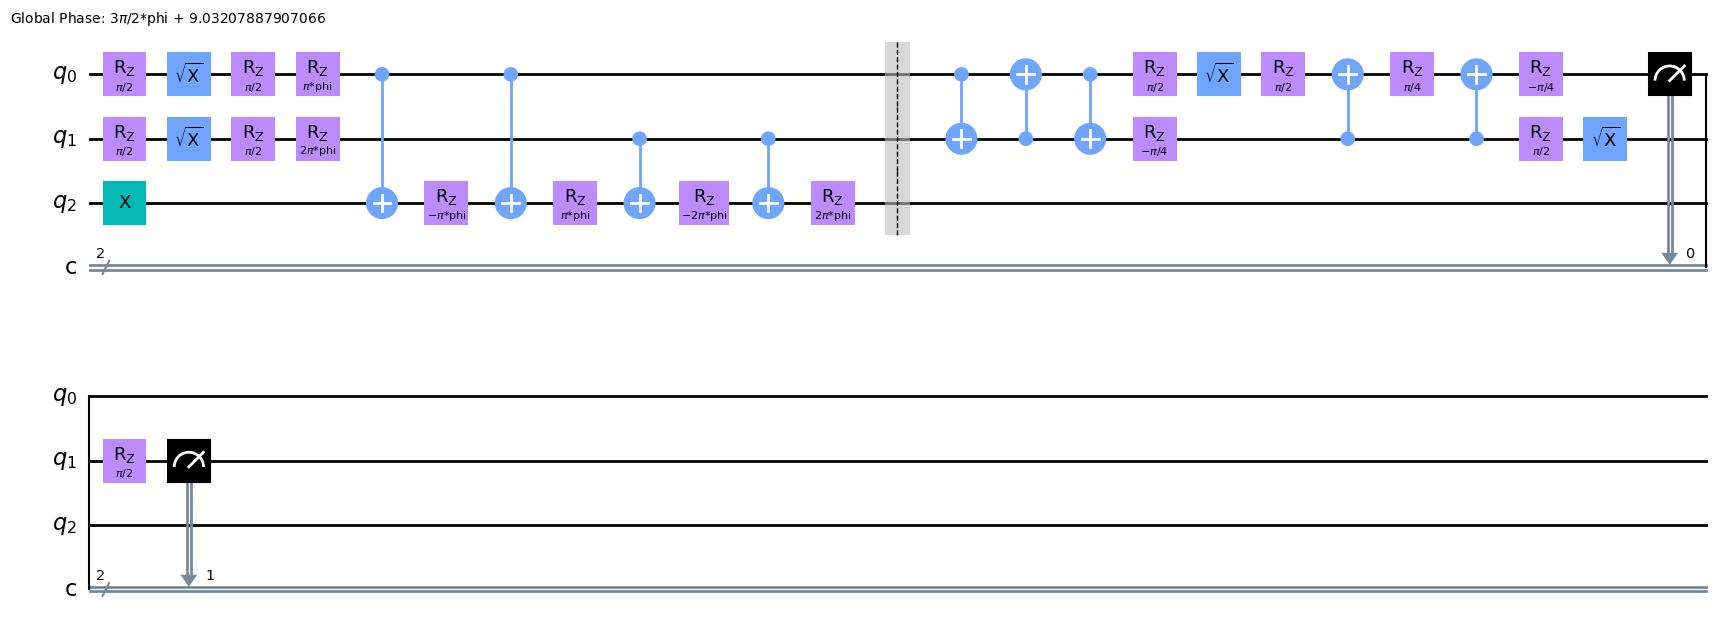

In [4]:
qc = transpile(qc, basis_gates= ["cx", "rz", "x", "sx"])
qc.draw(output="mpl")

In [5]:
from qiskit import Aer, transpile
simulator = Aer.get_backend('aer_simulator')
results = simulator.run(qc).result()
answer = results.get_counts()

from qiskit.visualization import plot_histogram
plot_histogram(answer)

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([Parameter(phi)])]'

In [ ]:
qc.draw(output="mpl")

# Grover

In [ ]:
from qiskit import *
from numpy import pi
import numpy as np
from qiskit.circuit.library import C3XGate
from qiskit.algorithms import Grover

num_iterations = 2
a = QuantumRegister(1, "a")
b = QuantumRegister(1, "b")
cond = QuantumRegister(1, "cond")
flag = QuantumRegister(1, "flag")
creg_c = ClassicalRegister(2, "classical")
circuit = QuantumCircuit(a, b,  cond, flag, creg_c)

circuit.h(a)
circuit.h(b)
circuit.x(flag)
circuit.h(flag)
circuit.barrier(a, b, cond, flag)
for i in range(num_iterations):

    
   # circuit.cx(a,b)
   # circuit.cx(b,cond)
    circuit.cx(a,cond)
    circuit.mcp(np.pi, cond, flag)
    circuit.cx(a,cond)
    #circuit.cx(b,cond)
   # circuit.cx(a,b)

    circuit.barrier(a, b, cond)
    circuit.h(a)
    circuit.h(b)
    circuit.x(a)
    circuit.x(b)
    circuit.mcp(np.pi, [a], b)
    circuit.x(b)
    circuit.x(a)
    circuit.h(b)
    circuit.h(a)
    circuit.barrier(a, b, cond)

circuit.measure(a, creg_c[0])
circuit.measure(b, creg_c[1])

circuit.draw(output="mpl", fold=-1)

In [ ]:
from mqt import ddsim

backend = ddsim.DDSIMProvider().get_backend("qasm_simulator")
job = execute(circuit, backend, shots=10000000)
counts = job.result().get_counts(circuit)

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram(counts, color="midnightblue", title="Histogram", figsize=(10, 5))

# MaxCut

In [6]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit_optimization.applications import Maxcut

In [7]:
n=4 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(2,3,1.0),(1,2,1.0)] # ,(0,2,1.0)
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)
colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

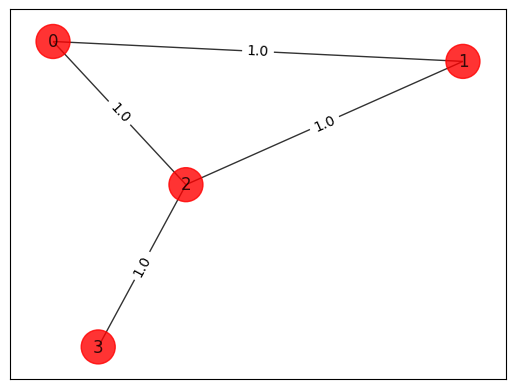

In [8]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [9]:
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[0. 1. 1. 0.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [0. 0. 1. 0.]]


In [10]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp)

maximize -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_2 - 2*x_2*x_3 + 2*x_0 + 2*x_1 + 3*x_2 + x_3 (4 variables, 0 constraints, 'Max-cut')


In [11]:
from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Sampler
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit import transpile

In [12]:
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
result

<MinimumEigenOptimizationResult: fval=3.0, x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, status=SUCCESS>

In [13]:
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=1, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
result

In [14]:
qaoa = QAOA(optimizer=SPSA(), sampler=Sampler())
res = qaoa.compute_minimum_eigenvalue(qubitOp)
print(res)

SamplingMinimumEigensolverResult:
	Eigenvalue: -0.1185657972417155
	Best measurement
: {'state': 4, 'bitstring': '0100', 'value': (-1+0j), 'probability': 0.1653646637562263}



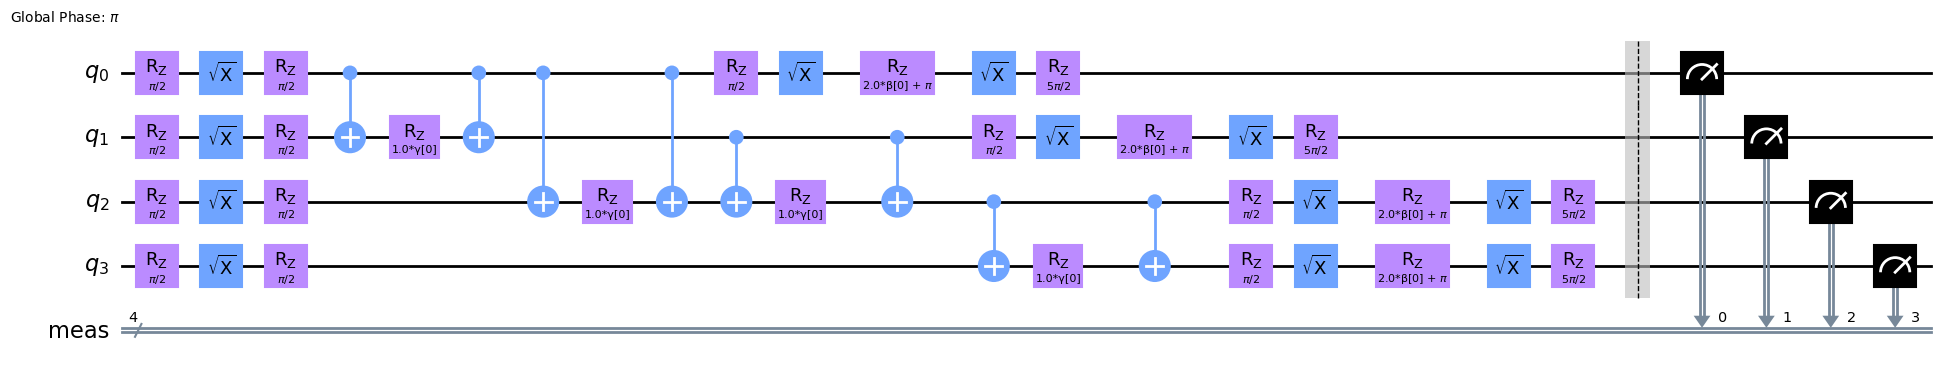

In [15]:
qc_transpiled = transpile(qaoa.ansatz, basis_gates=["cx", "sx", "x", "rz"])
qc_transpiled.draw(output="mpl", fold=-1)

# Add Placeholder

In [16]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit import Gate

In [17]:
p1 = Parameter('a')
p2 = Parameter('b')

In [18]:
unknown_edges = Gate(name='unknown_edges', num_qubits=3, params=[])

In [19]:
decomp_qc = QuantumCircuit(3)
decomp_qc.id([0,1,2])

unknown_edges.add_decomposition(decomp_qc)

In [20]:
from qiskit.circuit import Instruction
from qiskit.circuit import CircuitInstruction
from typing import Union
class Placeholder(Instruction):
    def __init__(self, num_qubits, label):
        self.name = "placeholder"
        super().__init__(self.name, num_qubits, 0, [], label = label)

    def inverse(self):
        return Placeholder(self.name, self.num_qubits)

# This function accepts a QuantumCircuit in addition to single instructions
# Note: you can modify it to accept a dictionary of label-instruction pairs.
def replace(self, placeholder_label, instruction: Union[Instruction, QuantumCircuit]):
    if isinstance(instruction, QuantumCircuit):
        instruction = instruction.to_instruction()

    self._data = [CircuitInstruction(instruction, _inst[1], _inst[2]) if _inst[0].name == 'placeholder' and _inst[0].label == placeholder_label else _inst for _inst in self._data]

QuantumCircuit.replace = replace

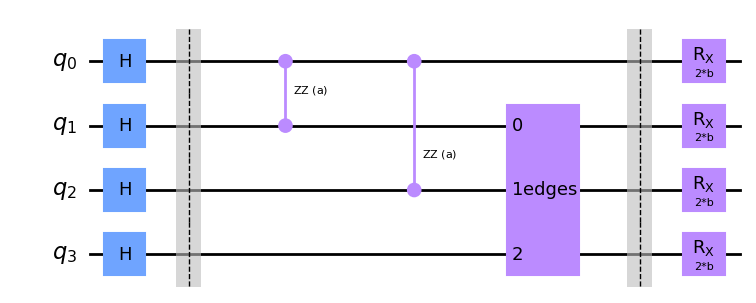

In [21]:
qc = QuantumCircuit(4)
qc.h([0,1,2,3])
qc.barrier()
qc.rzz(p1, 0,1)
qc.rzz(p1, 0,2)

#qc.append(unknown_edges, [1,2,3])
qc.append(Placeholder(3, 'edges'), [1,2,3])

qc.barrier()
qc.rx(2*p2, [0,1,2,3])
qc.draw(output="mpl")

## Quantum Circuit Nat Gates Creation

In [22]:
def create_init_qc(unknown=False):
    qc = QuantumCircuit(4)
    qc.h([0,1,2,3])
    qc.barrier()
    qc.rzz(p1, 0,1)
    qc.rzz(p1, 0,2)
    qc = transpile(qc, basis_gates=["cx", "sx", "x", "rz"])

    qc_mixer=QuantumCircuit(4)
    qc_mixer.rx(2*p2, [0,1,2,3])
    qc_mixer = transpile(qc_mixer, basis_gates=["cx", "sx", "x", "rz"])
    
    if unknown:
        qc.append(Placeholder(3, 'edges'), [1,2,3])
    qc.barrier()
    qc.compose(qc_mixer, [0,1,2,3], inplace=True)
    return qc

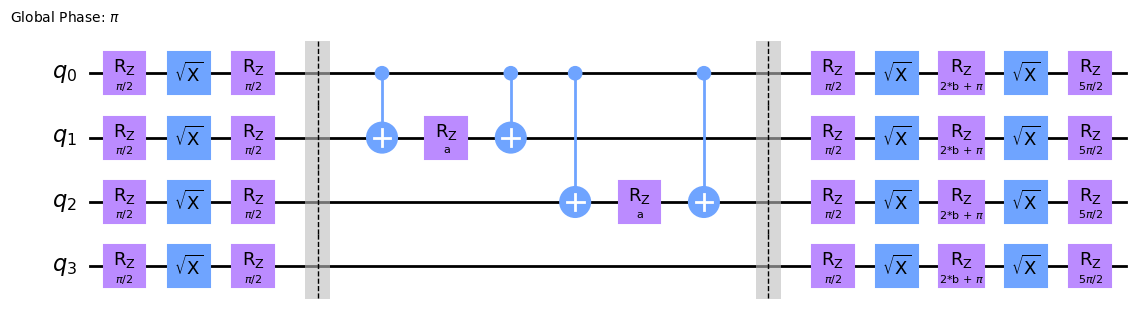

In [23]:
qc_nat_known = create_init_qc(False)
qc_nat_known.draw(output="mpl")

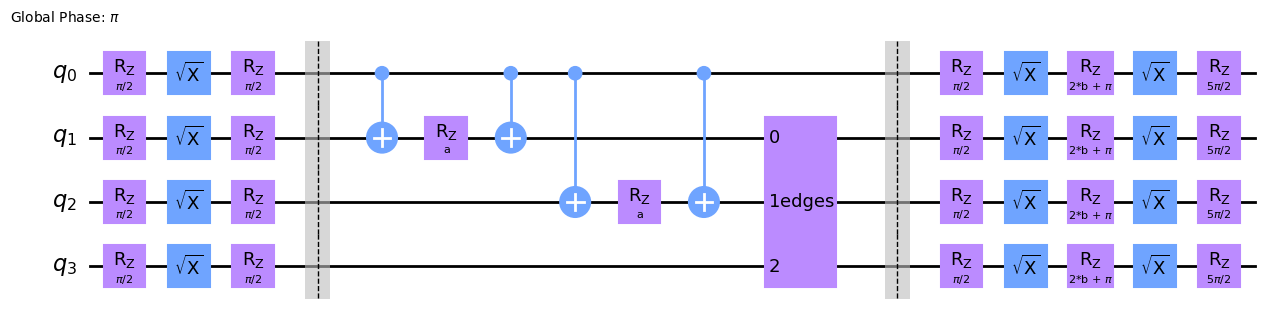

In [24]:
qc_nat_unknown = create_init_qc(True)
qc_nat_unknown.draw(output="mpl")

## Determine good mapping layout for qc without unknown part

In [25]:
from qiskit.providers.fake_provider import FakeManila
device = FakeManila()
coupling_map=device.configuration().coupling_map
qubit_offset = qc.num_qubits

/Users/nils/miniforge3/envs/MQTProblemSolver39/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/nils/miniforge3/envs/MQTProblemSolver39/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


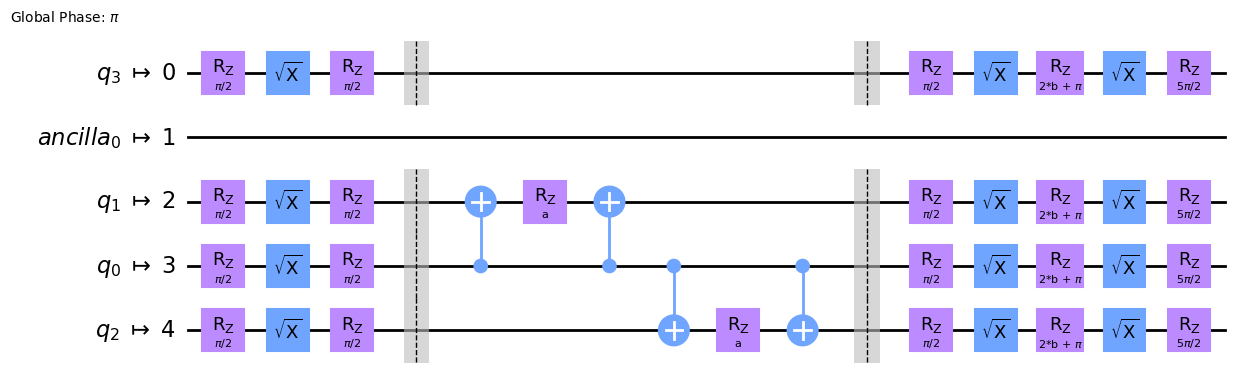

In [26]:
offline_mapped_qc = transpile(qc_nat_known, coupling_map=coupling_map, basis_gates=["cx", "sx", "x", "rz"], optimization_level=3)
offline_mapped_qc.draw(output="mpl")

In [27]:
layout = offline_mapped_qc._layout.initial_layout
mapping = []
for elem in layout.get_virtual_bits():
    if elem.register.name == "ancilla":
        pass#mapping[layout.get_virtual_bits()[elem]] = elem.index + qubit_offset
    else:
        mapping.append(layout.get_virtual_bits()[elem])

mapping

/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_6334/24772482.py:4: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  if elem.register.name == "ancilla":


[3, 2, 4, 0]

# Add new gates at online time

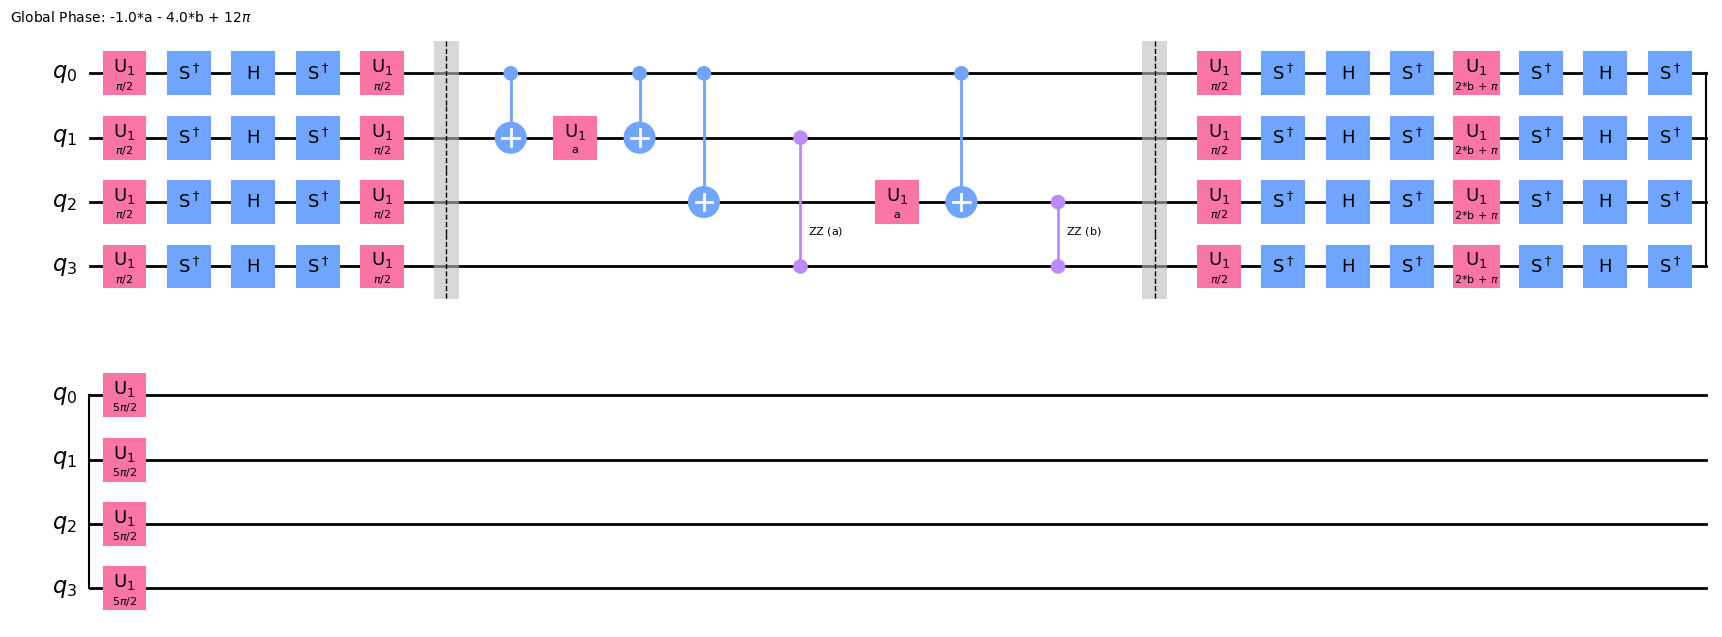

In [28]:
new_edges = QuantumCircuit(3)
new_edges.rzz(p1, 0,2)
new_edges.rzz(p2, 1,2)

qc_nat_unknown.replace('edges', new_edges)
qc_nat_unknown.decompose().draw(output="mpl")

## Compile circuit with new gates according to pre-calculated layout

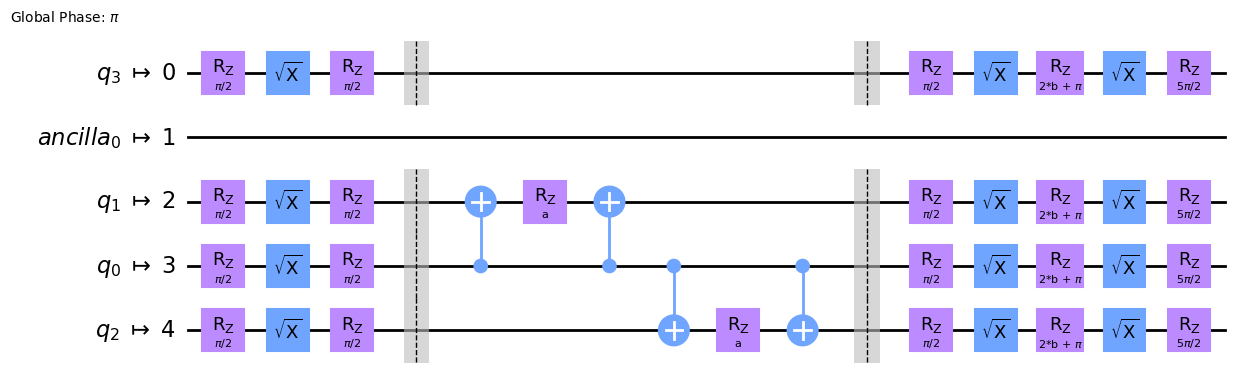

In [29]:
offline_mapped_qc.draw(output="mpl")

In [30]:
#mapped_online = transpile(qc, coupling_map=coupling_map, basis_gates=["cx", "sx", "x", "rz"], initial_layout=list(mapping.values()), layout_method="trivial", optimization_level=0)
mapped_online = transpile(qc_nat_unknown, coupling_map=coupling_map, basis_gates=["cx", "sx", "x", "rz"], initial_layout=mapping, layout_method="trivial", optimization_level=3)

/Users/nils/miniforge3/envs/MQTProblemSolver39/lib/python3.9/site-packages/qiskit/compiler/transpiler.py:624: UserWarning: initial_layout provided; layout_method is ignored.
  warnings.warn("initial_layout provided; layout_method is ignored.", UserWarning)


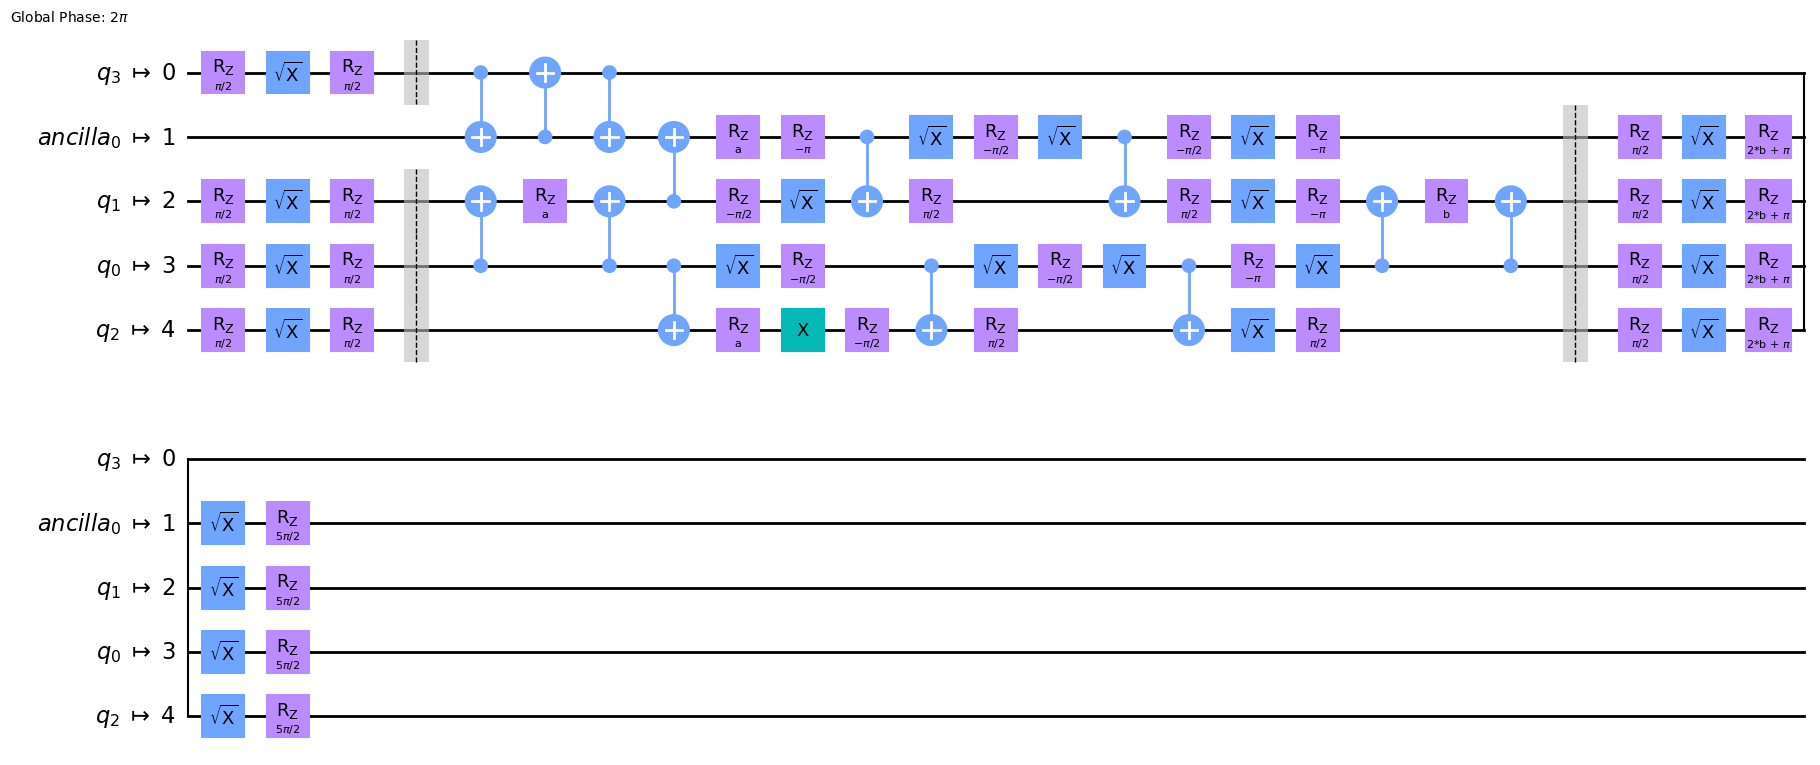

In [31]:
mapped_online.draw(output="mpl")

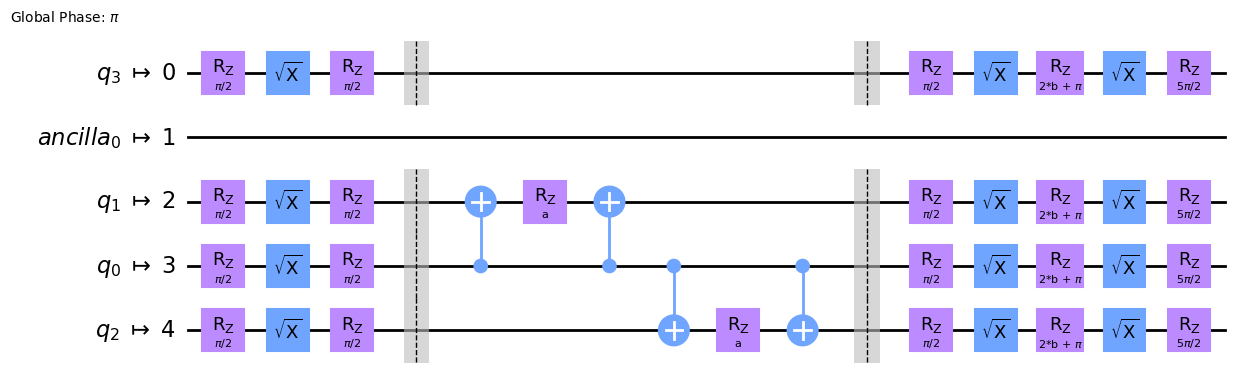

In [32]:
offline_mapped_qc.draw(output="mpl")